# Modelos usando el algoritmo de arboles de decisión

# Importación de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import preprocessing
from sklearn.model_selection import train_test_split
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

# Llamado a funciones de preprocesamiento

## Conversión de variables
- Hay que convertir todos los features categóricos a númericos. Para variables categóricas se usarán Dummy Variables y para ordinales OrdinalEncoder.

In [3]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.remove_irrelevant_features(X)
X = preprocessing.one_hot_encodding(X)

# Se separa el dataset en entrenamiento y holdout
y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train, X_test = preprocessing.escalar(X_train, X_test)

# Modelos

## Modelo 1

In [5]:
from keras.regularizers import l2


mc = keras.callbacks.ModelCheckpoint('mejor_modelo.h5', monitor='accuracy', mode='max')
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=50, mode='max')

model = Sequential()
model.add(Dense(8, input_shape=(40,), activation='tanh', kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation="sigmoid"))

opt = keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    validation_data=(X_test, y_test),
    callbacks=[custom_early_stopping, mc],
)

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
713/713 [==============================] - 3s 3ms/step - loss: 0.7537 - accuracy: 0.5114 - val_loss: 0.6547 - val_accuracy: 0.6105
Epoch 2/200
713/713 [==============================] - 2s 2ms/step - loss: 0.6271 - accuracy: 0.6519 - val_loss: 0.5689 - val_accuracy: 0.7227
Epoch 3/200
713/713 [==============================] - 1s 1ms/step - loss: 0.5503 - accuracy: 0.7450 - val_loss: 0.5098 - val_accuracy: 0.7673
Epoch 4/200
713/713 [==============================] - 1s 2ms/step - loss: 0.4978 - accurac

Gráfico de accuracy de train y test para verificar que no haya overfitting.

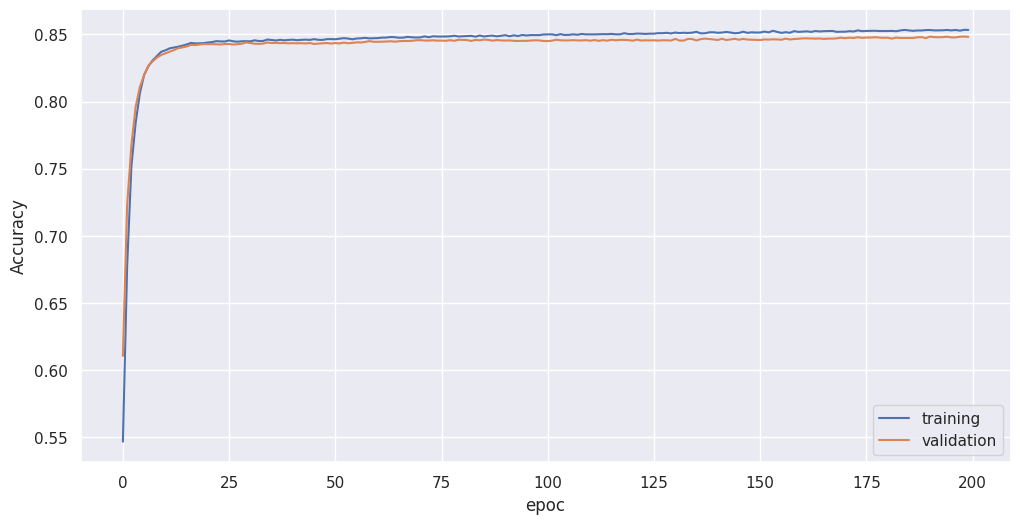

In [6]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()

### Métricas


Curva AUC-ROC, Accuracy, Precision, Recall, F1 score:

In [37]:
from sklearn.metrics import plot_roc_curve

prediction = model.predict_classes(X_test)
(accuracy, precision, recall, f1score, roc) = preprocessing.calcular_metricas(y_test, prediction)
print(f"Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF1-score: {f1score} \nCurva ROC-AUC:")
# roc = plot_roc_curve(model.predict_classes, X_test, y_test)

Accuracy: 0.8481932644078206 
Precision: 0.7194208686969545 
Recall: 0.9241258269204806 
F1-score: 0.6602520045819015 
Curva ROC-AUC:
